Importing relevant packages and modules

In [1]:
import sys
from pathlib import Path

# Plotting
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from Experiment import Experiment
from stats import grid_score_masks, get_smooth_ratemaps, grid_orientation, grid_spacing, apply_scalarFn_to_selection, scalar_shifts, phase_shifts, circular_kernel

/home/konstantin/anaconda3/envs/emergent-gcs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the Experiment data

In [2]:
base_path = Path("/storA/GridCells/")
experiment = Experiment(name="3ME", base_path=base_path)
experiment.setup()

Experiment <3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


False

Create the masks based on specified selection scheme (grid score, topology, ...)

In [3]:
gs_masks = grid_score_masks(experiment, percentile=0.4, mode="intersection")

## Plotting

Plotting style related settings. Loading notebook stylesheet and setting the colors of the cycler. Colors are either based on the officiel BioAI color scheme or on the diverging color scheme from [ColorBrewer2](https://colorbrewer2.org/#type=diverging&scheme=BrBG&n=3).

In [8]:
plt.style.use(['seaborn-paper', './notebook.mplstyle'])

# BioAI color scheme
bioAI_dark_blue = '#194587'
bioAI_bright_blue = '#1ca6e6'
bioAI_background_grey = '#e8e8e8'
bioAI_colors = [bioAI_dark_blue, bioAI_bright_blue, bioAI_background_grey]

# ColorBrewer diverging
gold = '#d8b365'
off_white = '#f5f5f5'
tyrkis = '#5ab4ac'
cb_diverge = [gold, off_white, tyrkis]

color_scheme=bioAI_colors

# create continuous uni-coloured color map
bioAI_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("bioAI", ['#ffffff', bioAI_dark_blue])

Retrieve and plot the different statistics based on smoothed versions of the ratemaps corresponding to the loaded experiment


In [5]:
smooth_ratemaps = get_smooth_ratemaps(experiment, sigma=1.0)

### Orientations

In [6]:
orientations = apply_scalarFn_to_selection(grid_orientation, smooth_ratemaps, gs_masks)

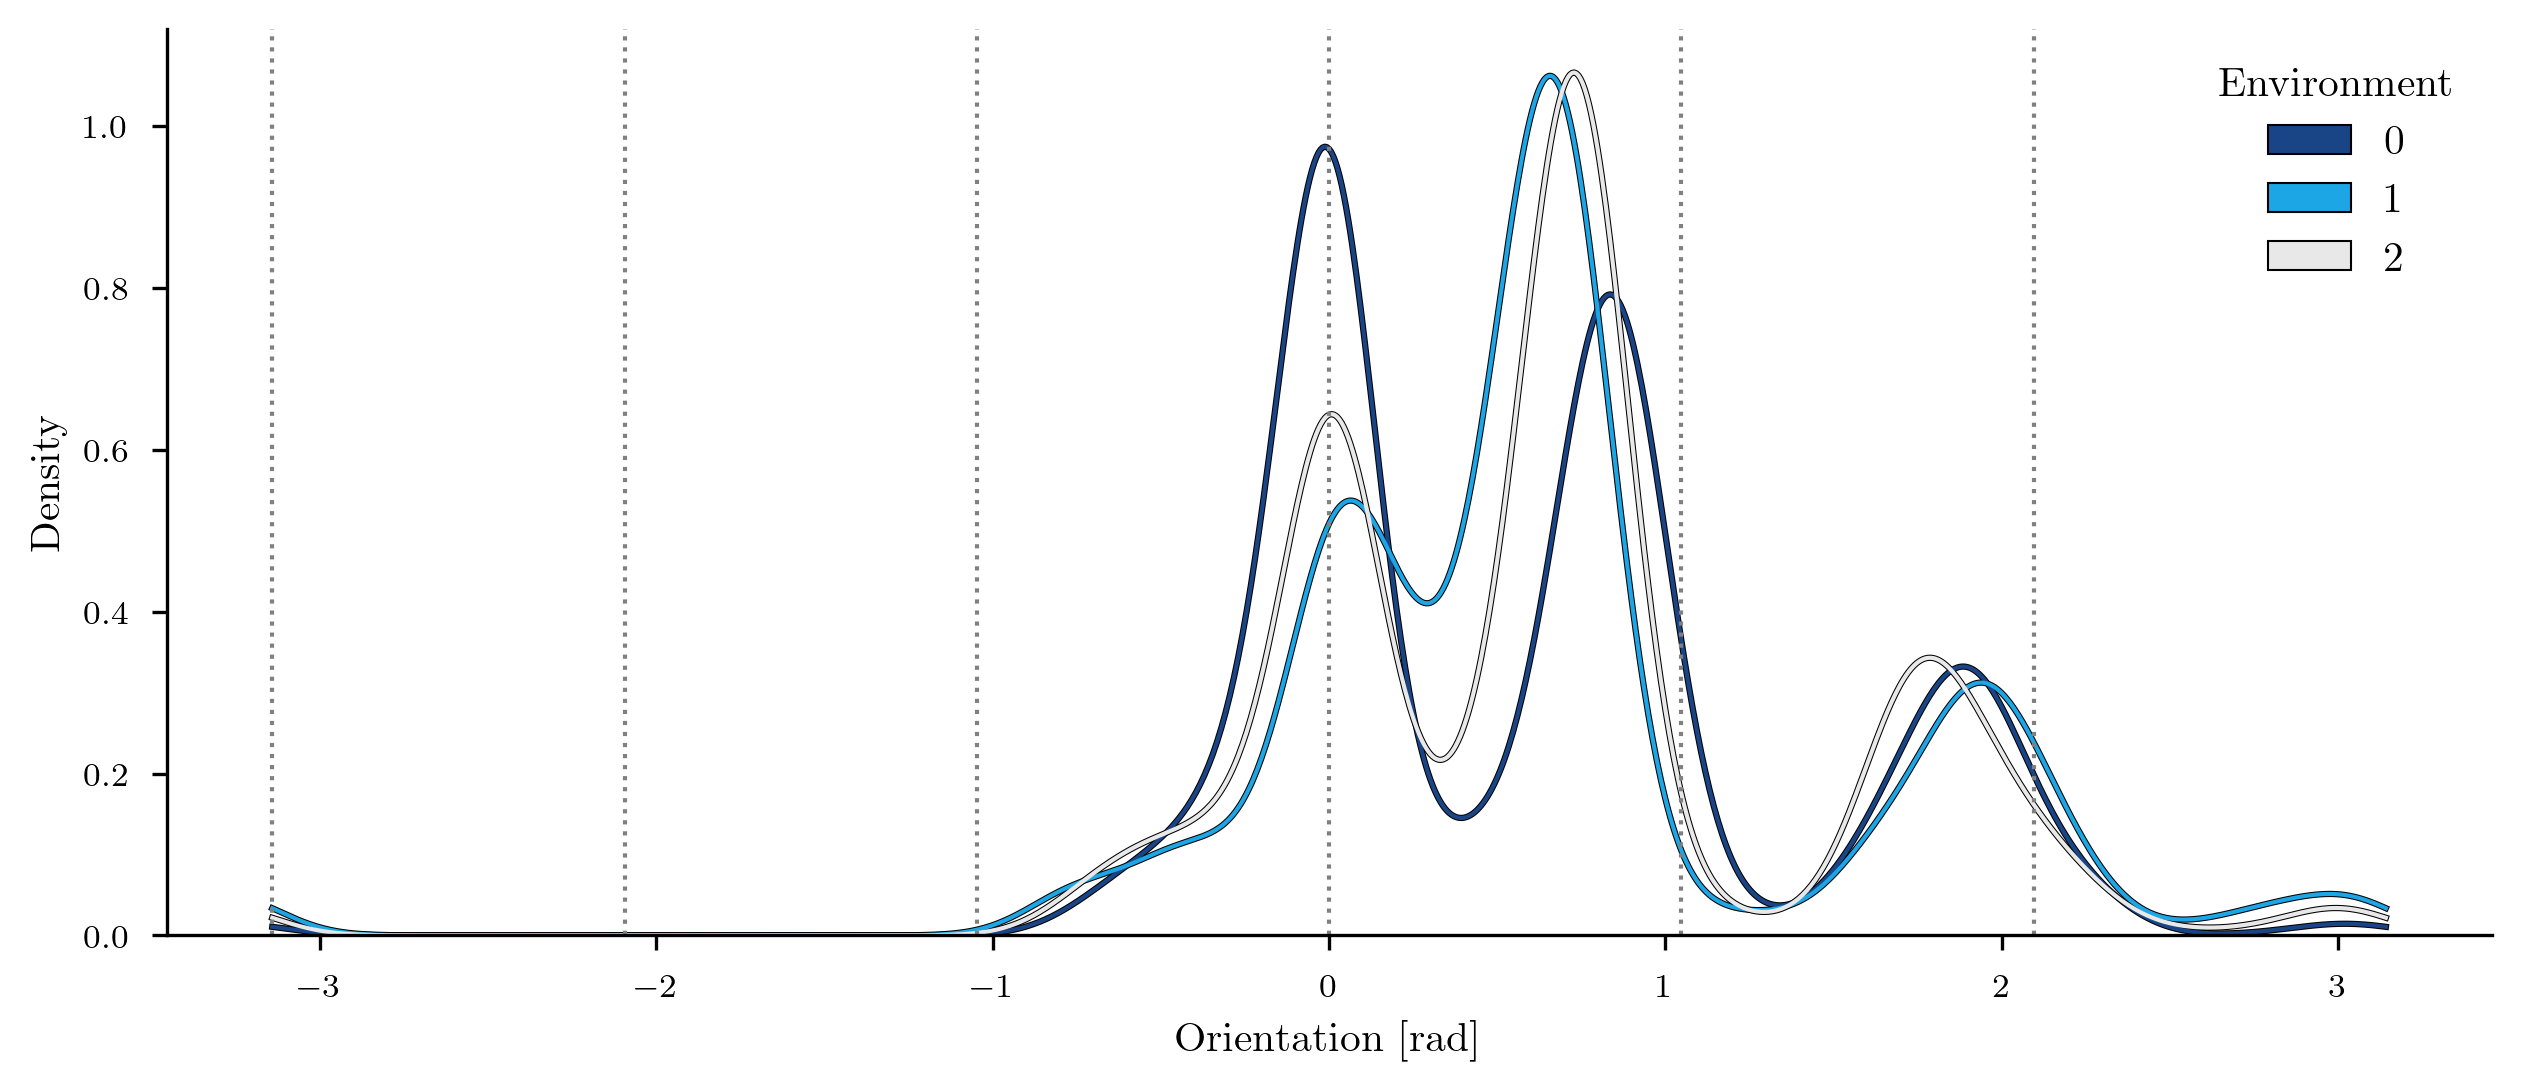

In [9]:
# von Mises KDE parameter
kappa = 50.0

thetas = np.linspace(-np.pi, +np.pi, num=1001)

fig, ax = plt.subplots()
patches = []
for env_i, orientations_env in enumerate(orientations):
    # Kernel density estimation with periodic gaussian kernel (von Mises kernel)
    # because orientation is 2-pi periodic
    von_mises_pdf = circular_kernel(orientations_env, kappa=kappa)
    ax.plot(
        thetas, 
        von_mises_pdf(thetas), 
        color=color_scheme[env_i], 
        linewidth=1.0,
        zorder=2
    ) # color
    ax.plot(
        thetas, 
        von_mises_pdf(thetas), 
        color='#000000', 
        linewidth=1.5,
        zorder=1
    )
    patches.append(
        mpatches.Patch(
            facecolor=color_scheme[env_i],
            label=r"$" + str(env_i) + "$",
            linewidth=0.5,
            edgecolor='#000000'
        )
    )
ymin, ymax = ax.get_ylim()
ax.set_ylim((ymin, ymax))
ax.vlines(
    np.array(
        [((60.0*i)*np.pi / 180.0) - np.pi for i in range(6)]
    ),
    ymin=ymin,
    ymax=ymax,
    color='grey',
    linestyles='dotted'
)
ax.set_ylim(bottom=0)
ax.set_ylabel(r"Density")
ax.set_xlabel(r"Orientation [rad]")
ax.legend(
    handles=patches,
    loc="upper right",
    title=r"Environment"
)
plt.show()

### Orientation Shifts

In [10]:
orientations = apply_scalarFn_to_selection(grid_orientation, smooth_ratemaps, gs_masks, rm_nan=False)
orientations_shifts = scalar_shifts(orientations)

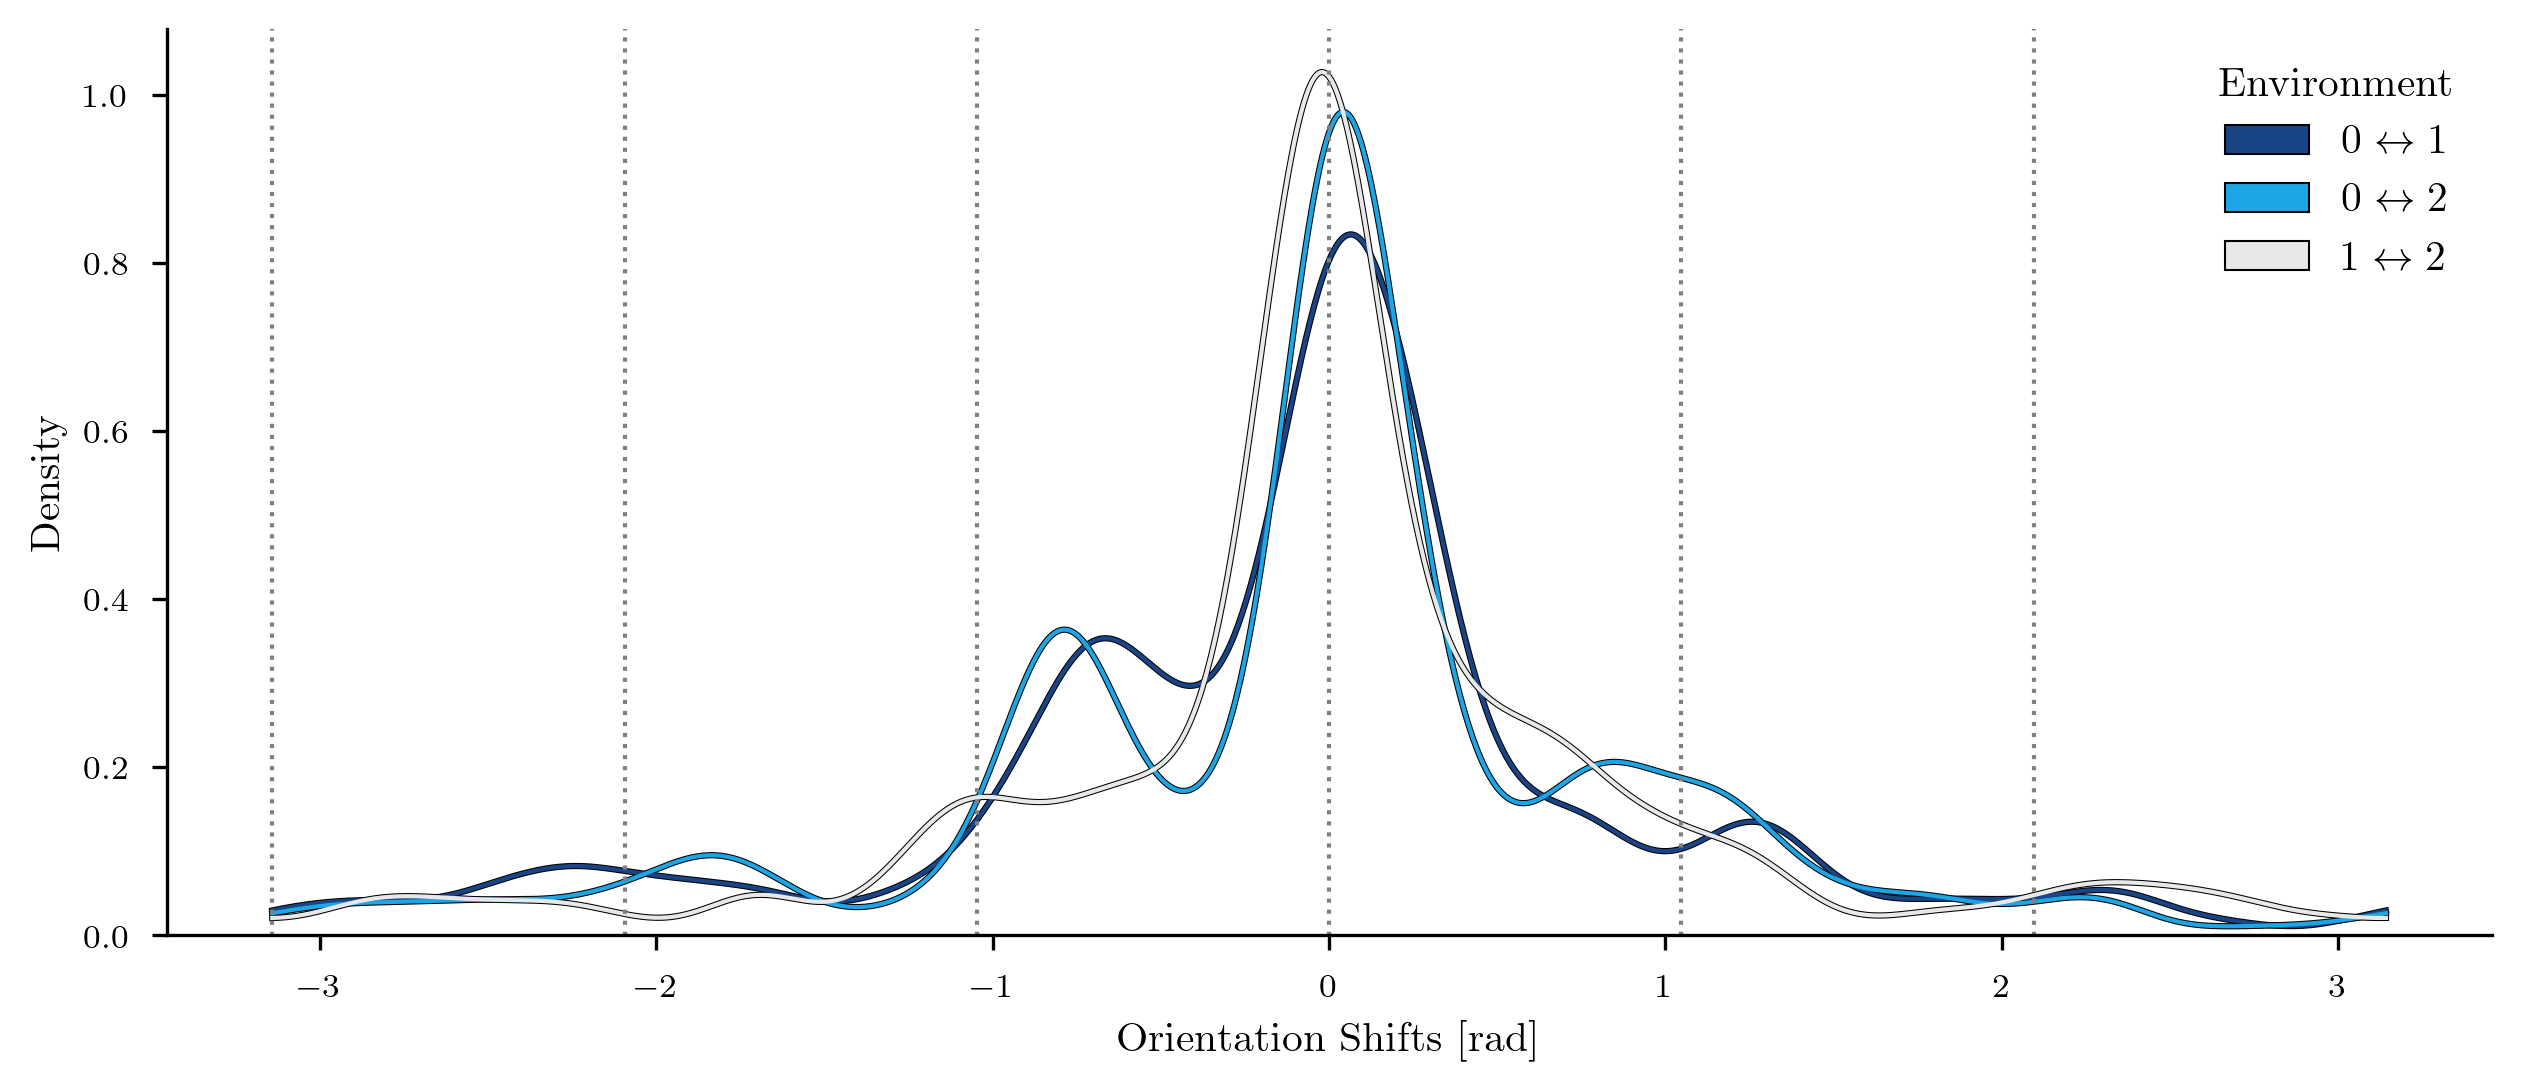

In [11]:
# von Mises KDE parameter
kappa = 50.0

thetas = np.linspace(-np.pi, +np.pi, num=1001)

no_envs = len(orientations_shifts)

fig, ax = plt.subplots()
patches = []

# iterate over upper triangular in environment indices
for env_i in range(no_envs):
    for env_j in range(env_i + 1, no_envs):
        
        # remove nans from shift array
        or_shifts = orientations_shifts[env_i, env_j]
        or_shifts = or_shifts[~np.isnan(or_shifts)]
    
        # Kernel density estimation with periodic gaussian kernel (von Mises kernel)
        # because orientation is 2-pi periodic
        von_mises_pdf = circular_kernel(or_shifts, kappa=kappa)
        pdf_vals = von_mises_pdf(thetas)
        
        ax_idx = env_i + env_j - 1
        
        ax.plot(
            thetas, 
            pdf_vals, 
            color=color_scheme[ax_idx], 
            linewidth=1.0,
            zorder=2
        ) # color
        ax.plot(
            thetas, 
            pdf_vals, 
            color='#000000', 
            linewidth=1.5,
            zorder=1
        )
        patches.append(
            mpatches.Patch(
                facecolor=color_scheme[ax_idx],
                label=r"$" + str(env_i) + " \leftrightarrow " + str(env_j) + "$",
                linewidth=0.5,
                edgecolor='#000000'
            )
        )

ymin, ymax = ax.get_ylim()
ax.set_ylim((ymin, ymax))
ax.vlines(
    np.array(
        [((60.0*i)*np.pi / 180.0) - np.pi for i in range(6)]
    ),
    ymin=ymin,
    ymax=ymax,
    color='grey',
    linestyles='dotted'
)
ax.set_ylim(bottom=0)
ax.set_ylabel(r"Density")
ax.set_xlabel(r"Orientation Shifts [rad]")
ax.legend(
    handles=patches,
    loc="upper right",
    title=r"Environment"
)
plt.show()

### Spacings

In [12]:
spacings_list = apply_scalarFn_to_selection(grid_spacing, smooth_ratemaps, gs_masks)

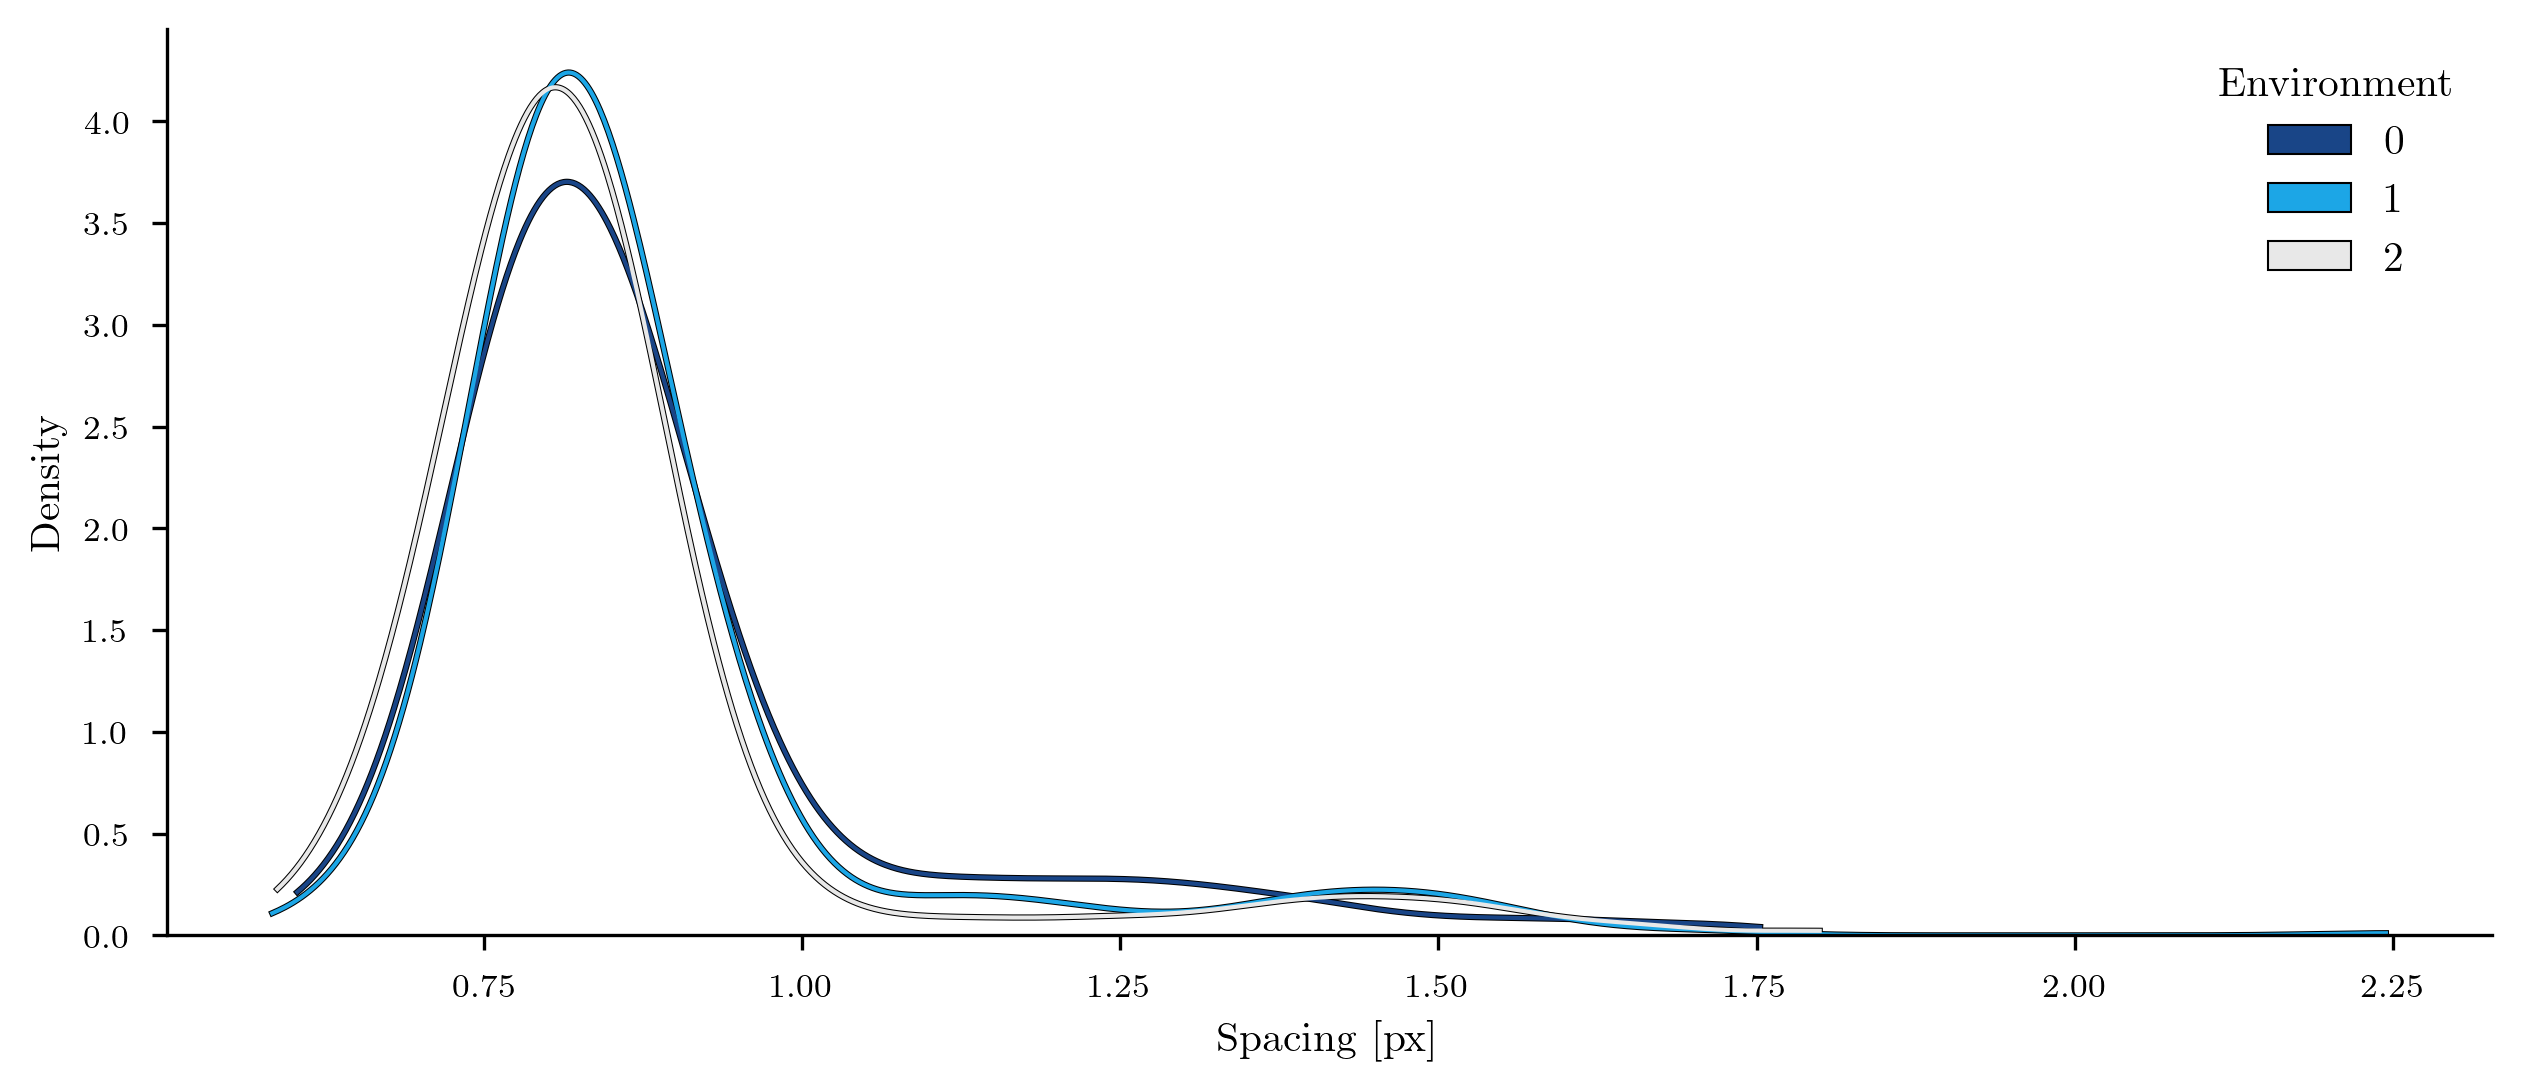

In [13]:
# kde parameter
bw_method = 0.3

fig, ax = plt.subplots()
patches=[]
for env_i, spacings_env in enumerate(spacings_list):
    # Kernel density estimation
    spacing_pdf = gaussian_kde(spacings_env, bw_method=bw_method)
    spacings = np.linspace(np.amin(spacings_env), np.amax(spacings_env), num=1001)
    ax.plot(
        spacings, 
        spacing_pdf(spacings),
        color=color_scheme[env_i],
        linewidth=1.0,
        zorder=2,
    )
    ax.plot(
        spacings,
        spacing_pdf(spacings),
        color='#000000',
        linewidth=1.5,
        zorder=1,
    )
    patches.append(
        mpatches.Patch(
            facecolor=color_scheme[env_i],
            label=r"$" + str(env_i) + "$",
            linewidth=0.5,
            edgecolor='#000000',
        )
    )
ax.set_ylim(bottom=0)
ax.set_ylabel(r"Density")
ax.set_xlabel(r"Spacing [px]")
ax.legend(
    handles=patches,
    loc="upper right",
    title=r"Environment"
)
plt.show()

### Spacing Shifts

In [14]:
spacings_list = apply_scalarFn_to_selection(grid_spacing, smooth_ratemaps, gs_masks, rm_nan=False)
spacings_shifts = scalar_shifts(spacings_list)

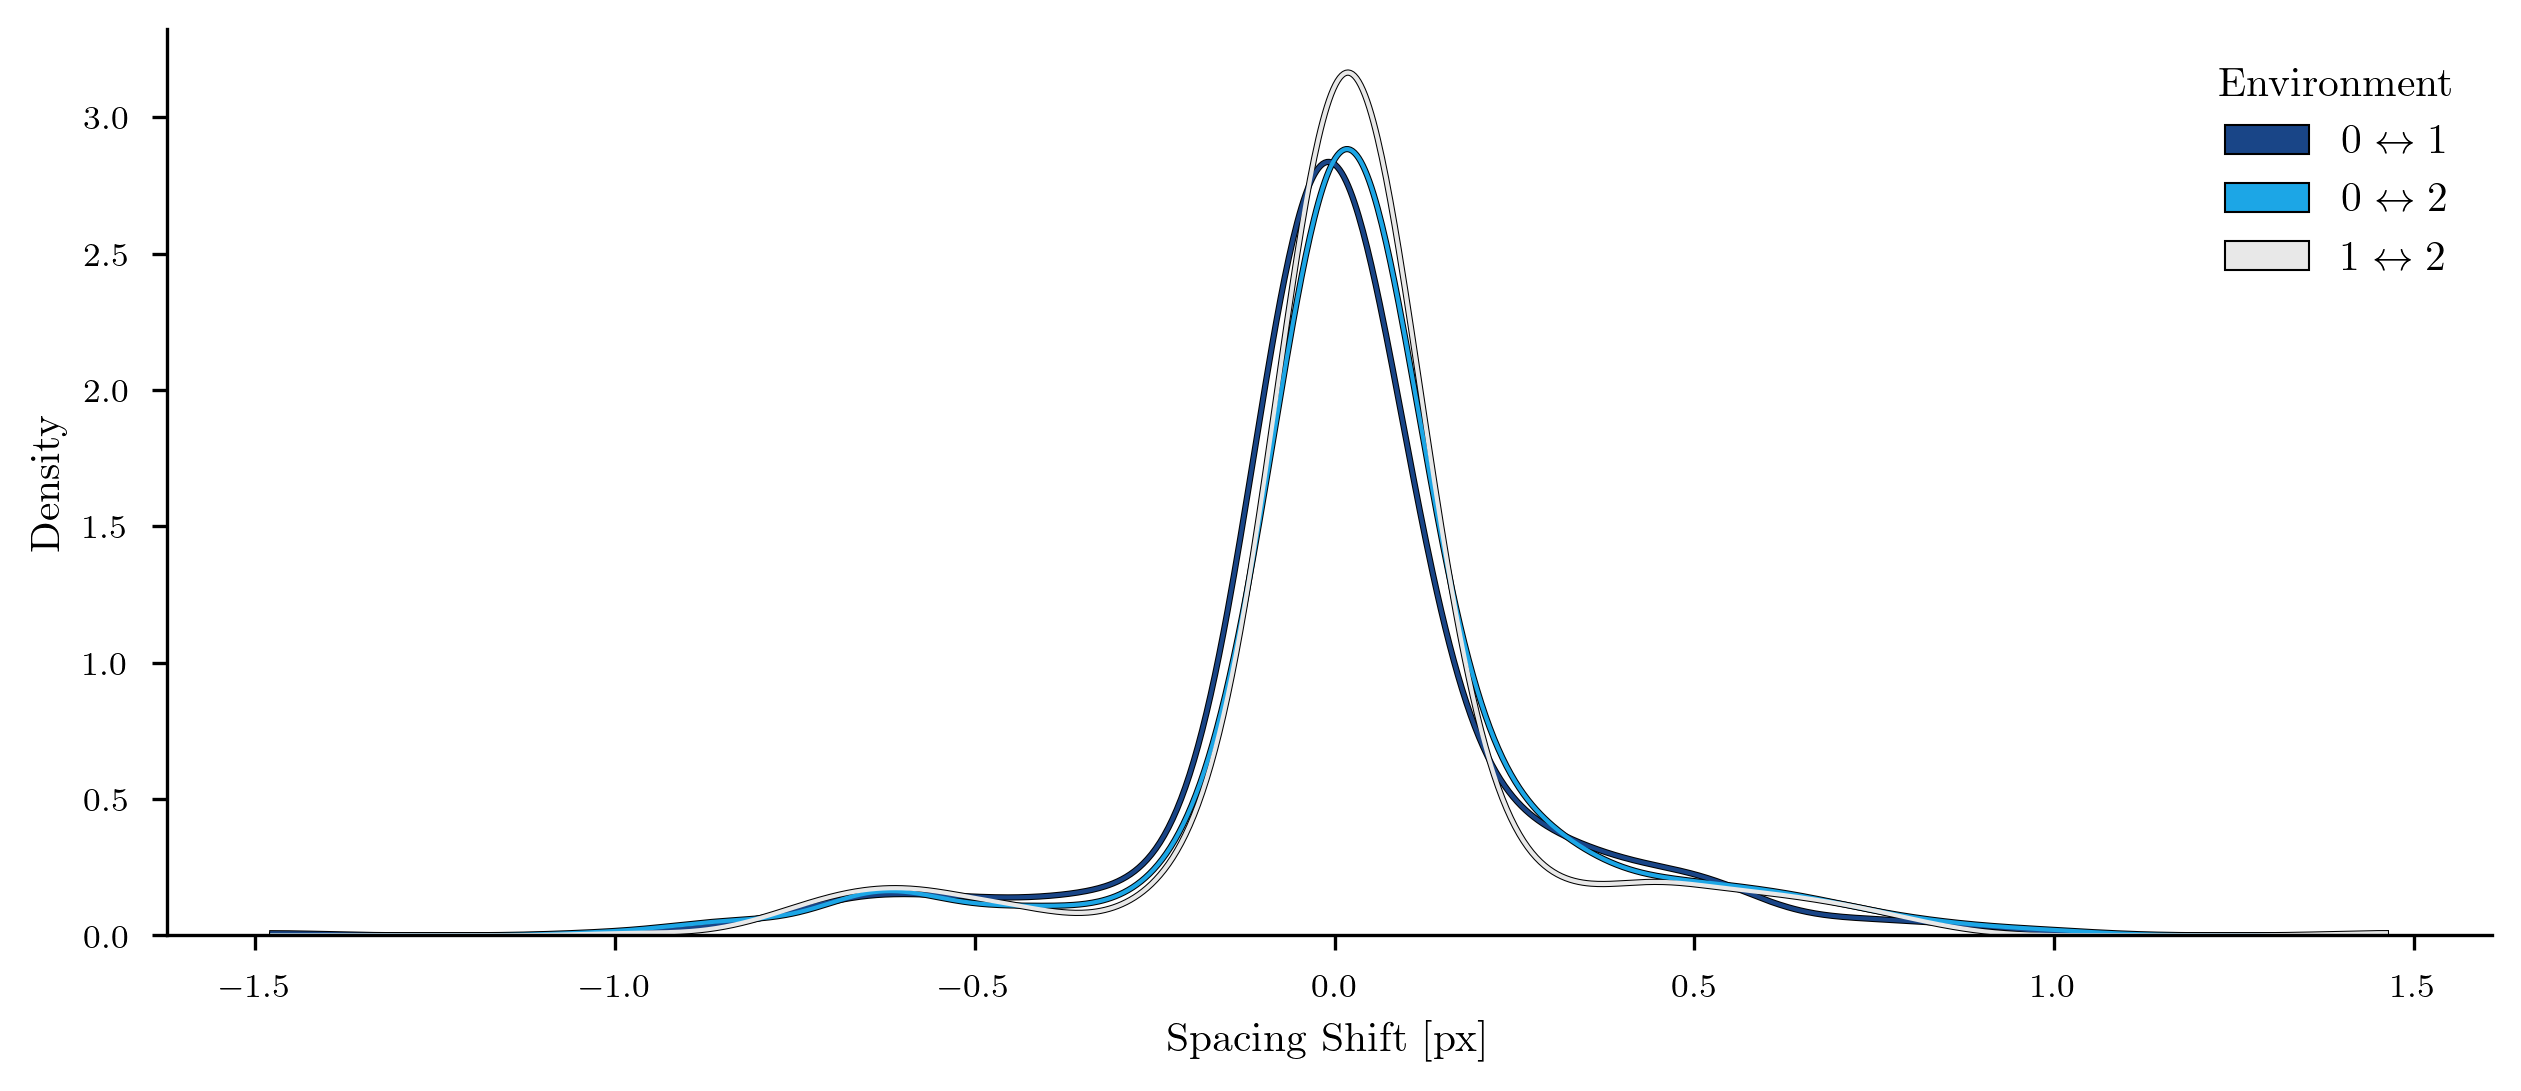

In [15]:
# parameter
res = 1001
# kde
bw_method = 0.3

no_envs = len(spacings_list)
max_shift = np.nanmax(spacings_shifts)
min_shift = np.nanmin(spacings_shifts)
spacings = np.linspace(min_shift, max_shift, num=res)

fig, ax = plt.subplots()
patches=[]

# iterate over upper triangular (shift statistics)
for env_i in range(no_envs):
    for env_j in range(env_i + 1, no_envs):
        
        # remove nan values
        sp_shifts = spacings_shifts[env_i, env_j]
        sp_shifts = sp_shifts[~np.isnan(sp_shifts)]
        
        # Kernel density estimation
        pdf = gaussian_kde(sp_shifts, bw_method=bw_method)
        pdf_vals = pdf(spacings)
        
        ax_idx = env_i + env_j - 1
        ax.plot(
            spacings, 
            pdf_vals,
            color=color_scheme[ax_idx],
            linewidth=1.0,
            zorder=2,
        )
        ax.plot(
            spacings,
            pdf_vals,
            color='#000000',
            linewidth=1.5,
            zorder=1,
        )
        patches.append(
            mpatches.Patch(
                facecolor=color_scheme[ax_idx],
                label=r"$" + str(env_i) + " \leftrightarrow " + str(env_j) + "$",
                linewidth=0.5,
                edgecolor='#000000',
            )
        )

ax.set_ylim(bottom=0)
ax.set_ylabel(r"Density")
ax.set_xlabel(r"Spacing Shift [px]")
ax.legend(
    handles=patches,
    loc="upper right",
    title=r"Environment"
)
plt.show()

### Phase Shifts

In [16]:
dPs = phase_shifts(smooth_ratemaps, gs_masks)

#### Vector distribution

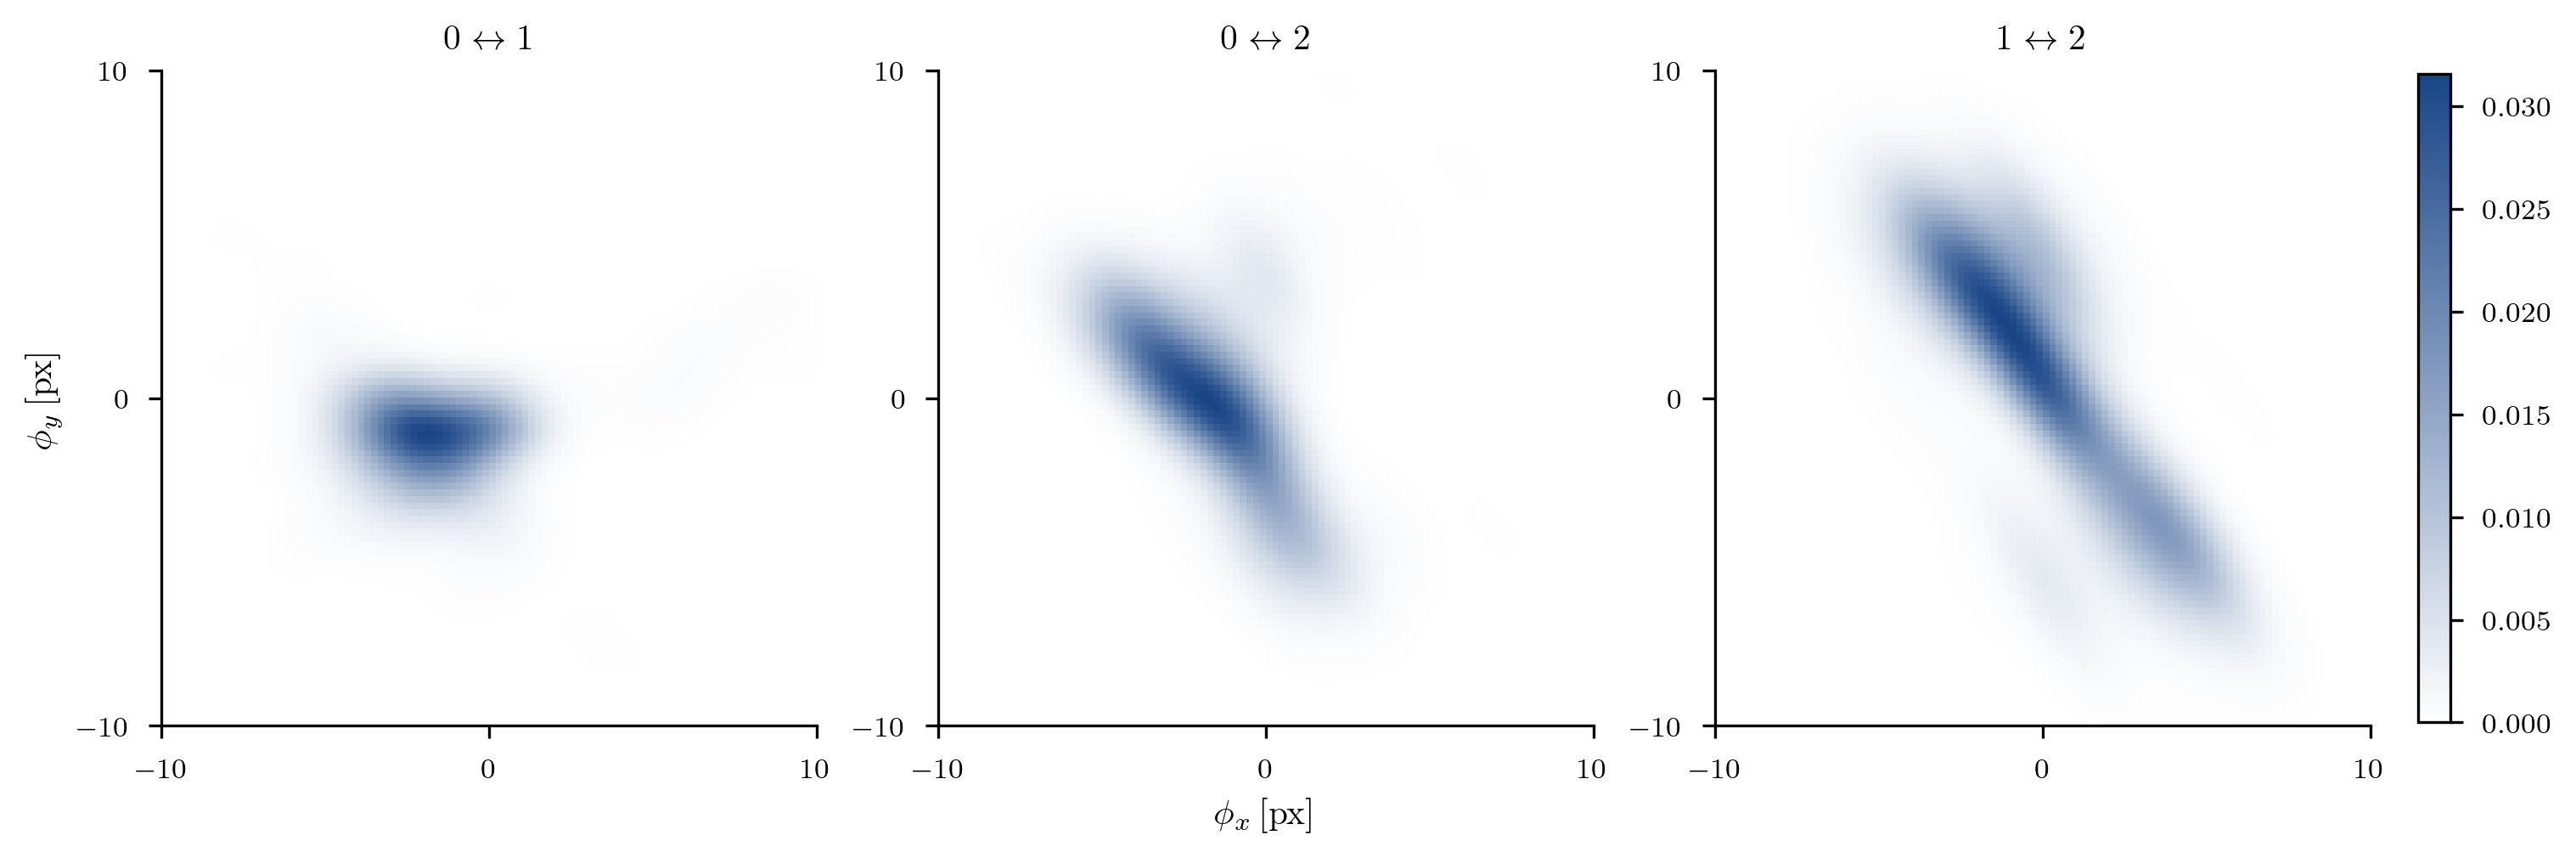

In [17]:
# parameter
res = 100
# kde
bw_method = 0.5


fig = plt.figure(constrained_layout=True)
widths = [3., 3., 3.]
heights = [3.]

spec = fig.add_gridspec(
    ncols = len(widths),
    nrows = len(heights),
    width_ratios = widths,
    height_ratios = heights,
)

axs = []
for p_i in range(len(widths)):
    axs.append(fig.add_subplot(spec[0, p_i]))

no_envs = dPs.shape[0]
max_val = np.nanmax(dPs)

ims = None

for env_i in range(no_envs):
    for env_j in range(env_i + 1, no_envs):
        
        ps = dPs[env_i, env_j]
        ps = ps[~np.isnan(ps).any(axis=1)]
        
        pdf = gaussian_kde(ps.T, bw_method=bw_method)
        
        p_xs = np.linspace(-max_val, max_val, num=res)
        p_ys = np.linspace(-max_val, max_val, num=res)
        xv, yv = np.meshgrid(p_xs, p_ys)
        coords = np.append(xv.reshape(-1,1), yv.reshape(-1,1), axis=1)
        pdf_vals = pdf(coords.T)

        ax_idx = env_i + env_j - 1
        
        axs[ax_idx].set_title(f"${env_i} \leftrightarrow {env_j}$")
        ims = axs[ax_idx].imshow(
            pdf_vals.reshape(res, res),
            cmap=bioAI_cmap,
            alpha=1.0,
            extent=[-max_val, max_val, -max_val, max_val]
        )
        axs[ax_idx].set_xlim((-max_val, max_val))
        axs[ax_idx].set_ylim((-max_val, max_val))
        axs[ax_idx].set_xticks([-max_val, 0.0, max_val])
        axs[ax_idx].set_yticks([-max_val, 0.0, max_val])
        axs[ax_idx].spines["left"].set_bounds(low=-max_val, high=max_val)
        axs[ax_idx].spines["bottom"].set_bounds(low=-max_val, high=max_val)
        
axs[0].set_ylabel(r"$\phi_{y}\, [\textrm{px}]$")
axs[1].set_xlabel(r"$\phi_{x}\, [\textrm{px}]$")
fig.colorbar(
    ims, 
    ax=axs[-1], 
    shrink=0.65,
) 
plt.show()

#### Magnitude distribution

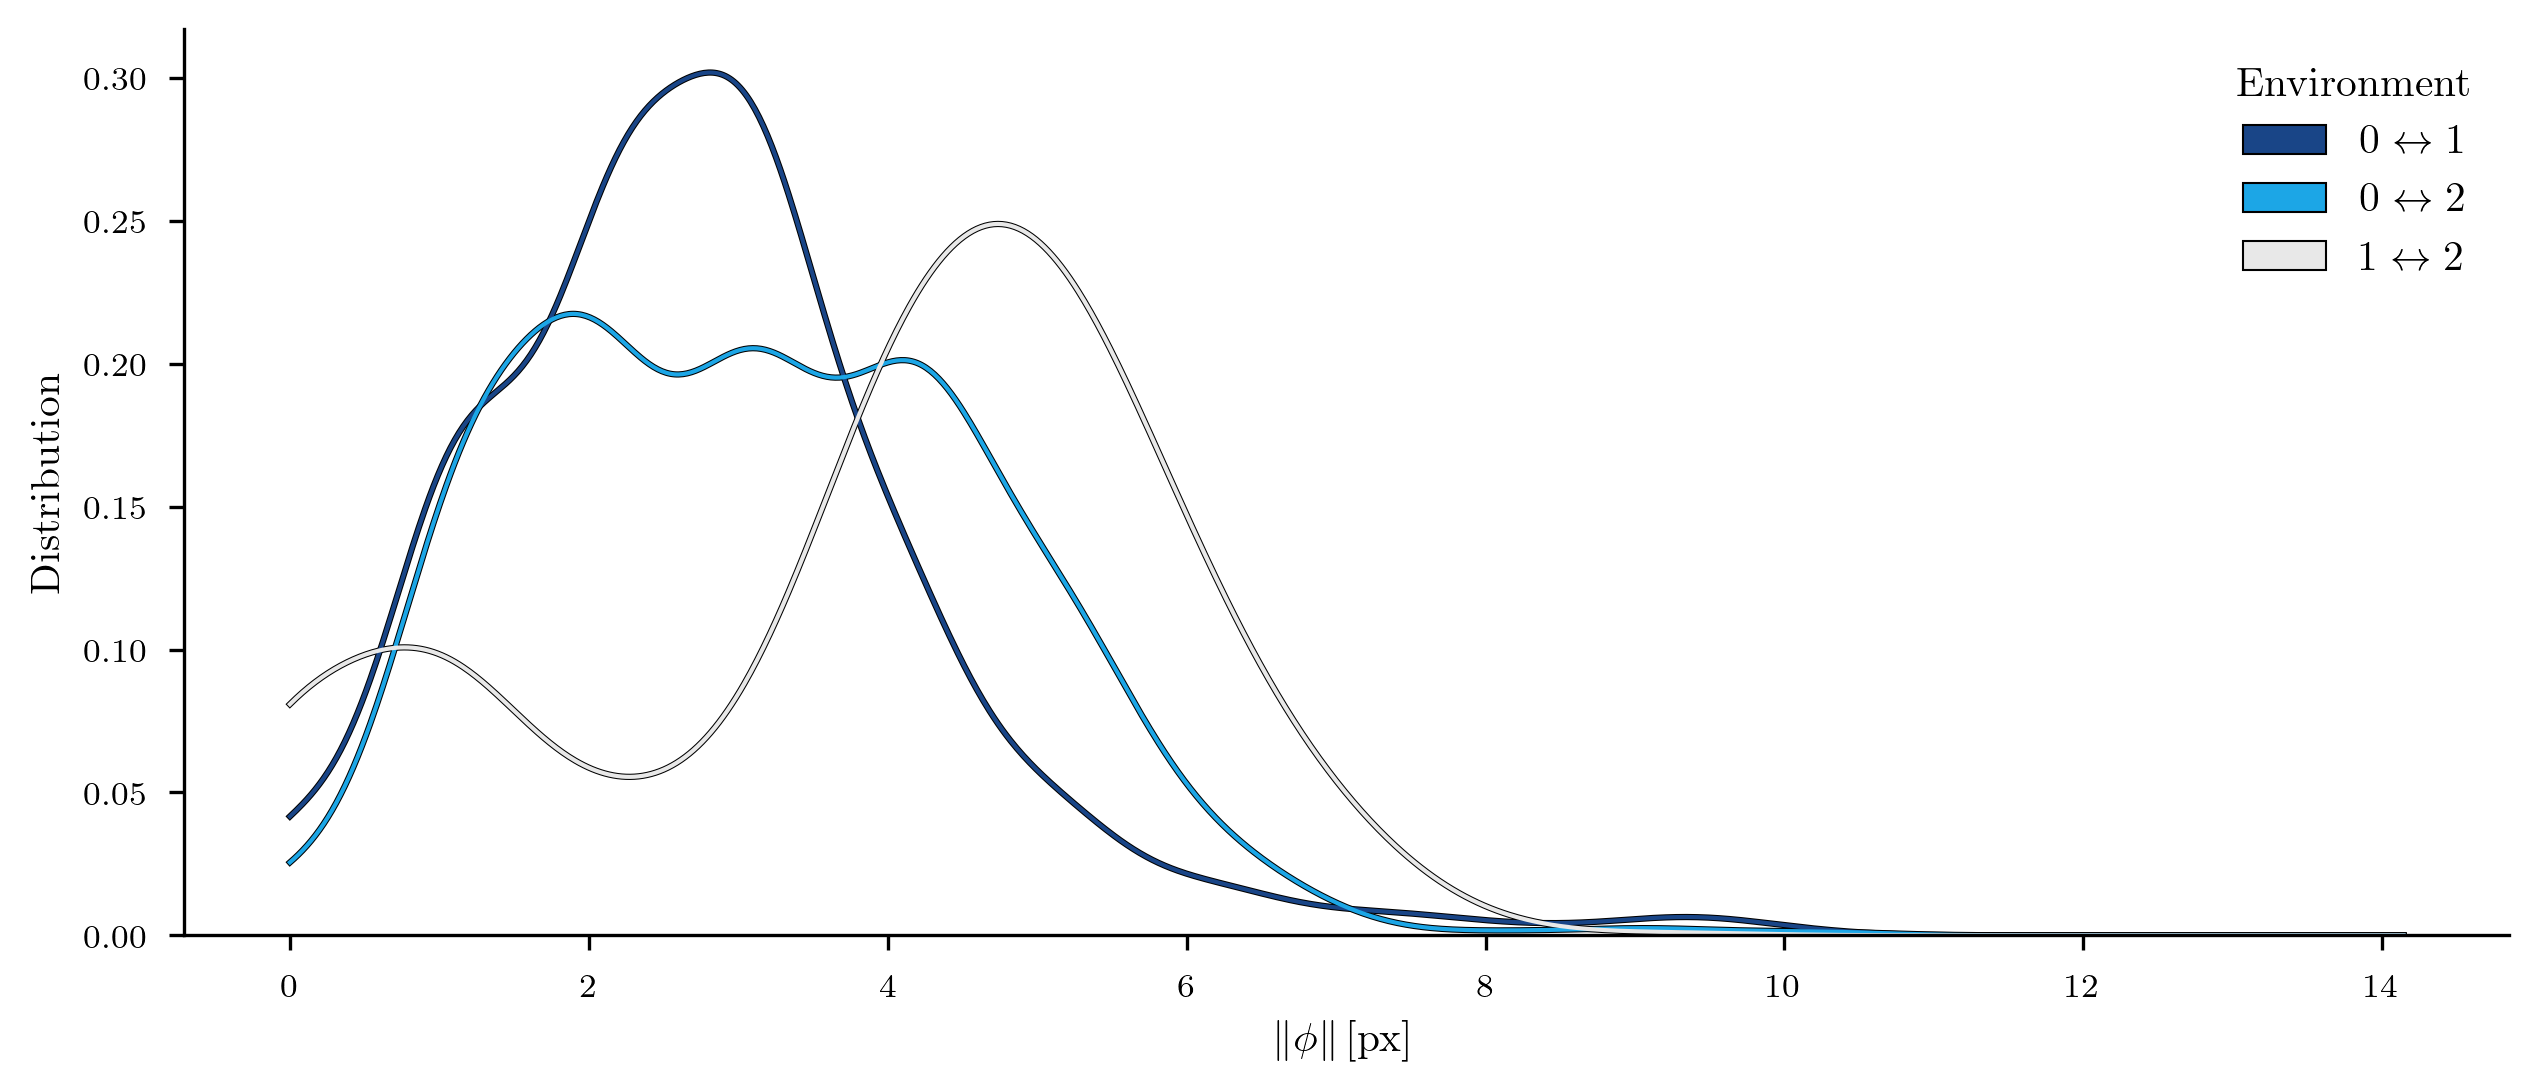

In [18]:
# parameter
res = 1001
# kde
bw_method = 0.3

no_envs = dPs.shape[0]
max_val = np.nanmax(dPs)
max_magnitude = np.sqrt(2)*max_val
magnitudes = np.linspace(0.0, max_magnitude, num=res)

fig, ax = plt.subplots()

patches = []
# iterate over upper triangular (shift statistics)
for env_i in range(no_envs):
    for env_j in range(env_i + 1, no_envs):
        
        ps = dPs[env_i, env_j]
        
        # remove nans from statistics
        ps = ps[~np.isnan(ps).any(axis=1)]
        ps_magnitude = np.linalg.norm(ps, axis=1)
        
        pdf = gaussian_kde(ps_magnitude, bw_method=bw_method)
        pdf_vals = pdf(magnitudes)
        
        ax_idx = env_i + env_j - 1
        ax.plot(
            magnitudes, 
            pdf_vals,
            color=color_scheme[ax_idx],
            linewidth=1.0,
            zorder=2
        )
        ax.plot(
            magnitudes,
            pdf_vals,
            color='#000000',
            linewidth=1.5,
            zorder=1,
        )
        patches.append(
            mpatches.Patch(
                facecolor=color_scheme[ax_idx],
                label=r"$" + str(env_i) + " \leftrightarrow " + str(env_j) + "$",
                linewidth=0.5,
                edgecolor='#000000',
            )
        )

ax.set_ylim(bottom=0.)
ax.set_ylabel(r"Distribution")
ax.set_xlabel(r"$\|\phi\|\, [\textrm{px}]$")
ax.legend(
    handles=patches,
    loc="upper right",
    title=r"Environment",
)
plt.show()